In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from einops import rearrange
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from mgca.datasets.transforms import DataTransforms
from mgca.constants import *
from mgca.datasets.data_module import DataModule
from mgca.datasets.pretrain_dataset import (MultimodalPretrainingDataset, 
                                            multimodal_collate_fn)
from mgca.models.mgca.mgca_module import MGCA

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
# Load pretrained model
ckpt_path = "../../pretrained/vit_base.ckpt"
model = MGCA.load_from_checkpoint(ckpt_path, strict=False)

In [3]:
# define datamodule
datamodule = DataModule(MultimodalPretrainingDataset, multimodal_collate_fn,
                        DataTransforms, 0.01, 64, 1)

for batch in datamodule.val_dataloader():
    break

  0%|          | 42/232421 [00:00<09:13, 419.86it/s]

Caption file /home/fywang/Documents/MGCA/mgca/datasets/../../data/captions.pickle does not exit. Creating captions...


100%|██████████| 232421/232421 [00:29<00:00, 7928.89it/s]


sent lens: 3,57.945360460811244,436 [24.0, 113.0]
num sents: 1,6.242778299165684,31 [2.0, 11.0]
Save to:  /home/fywang/Documents/MGCA/mgca/datasets/../../data/captions.pickle


In [4]:
with torch.no_grad():
    # Forward of query image encoder
    img_feat_q, patch_feat_q = model.img_encoder_q(
        batch["imgs"])
    patch_emb_q = model.img_encoder_q.local_embed(patch_feat_q)
    patch_emb_q = F.normalize(patch_emb_q, dim=-1)
    img_emb_q = model.img_encoder_q.global_embed(img_feat_q)
    img_emb_q = F.normalize(img_emb_q, dim=-1)

    # Forward of query text encoder
    report_feat_q, word_feat_q, word_attn_q, sents = model.text_encoder_q(
        batch["caption_ids"], batch["attention_mask"], batch["token_type_ids"])
    word_emb_q = model.text_encoder_q.local_embed(word_feat_q)
    word_emb_q = F.normalize(word_emb_q, dim=-1)
    report_emb_q = model.text_encoder_q.global_embed(report_feat_q)
    report_emb_q = F.normalize(report_emb_q, dim=-1)

    # Compute patch attention weights
    bz = img_emb_q.size(0)
    img_attn_map = model.img_encoder_q.model.blocks[-1].attn.attention_map.detach(
    )
    atten_weights = img_attn_map[:, :, 0, 1:].mean(dim=1)
    patch_atten_weights = []
    for i in range(bz):
        atten_weight = atten_weights[i]
        atten_weight = atten_weight.clip(torch.quantile(
            atten_weight, 0.1), torch.quantile(atten_weight, 0.9))
        patch_atten_weights.append(atten_weight.clone())
    patch_atten_weights = torch.stack(patch_atten_weights)

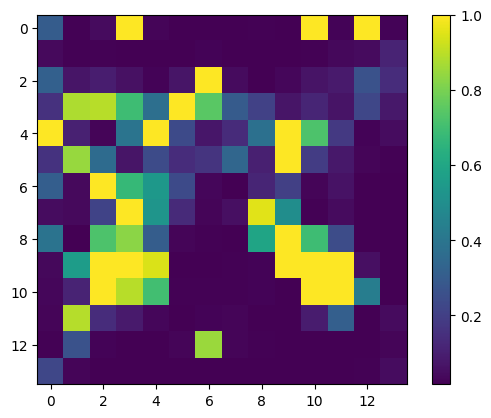

In [5]:
patch_atten_weights /= patch_atten_weights.max(dim=1)[0][:, None]
plt.imshow(patch_atten_weights[0].view(14, 14))
plt.colorbar()

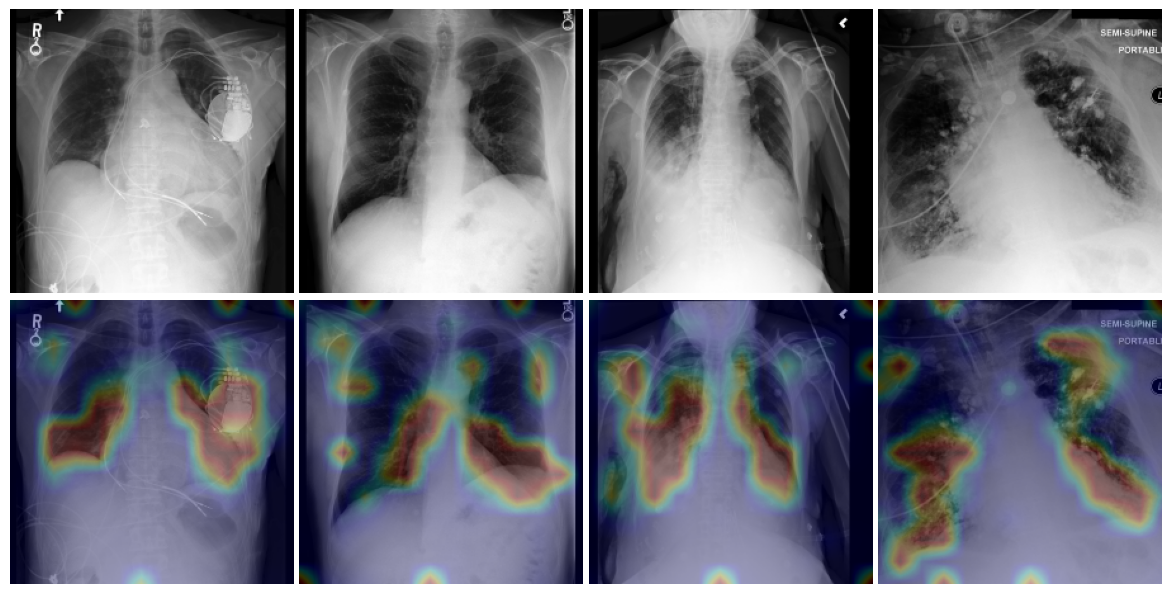

In [6]:
fig, axes = plt.subplots(2, 4)
fig.set_figheight(6)
fig.set_figwidth(12)
for i, idx in enumerate([1, 3, 5, 7]):
    atten_map = rearrange(1 - patch_atten_weights,
                          "b (p1 p2) -> b p1 p2", p1=14, p2=14)
    # atten_map = atten_map.repeat_interleave(16, 1).repeat_interleave(16, 2)
    atten_map = F.interpolate(atten_map.unsqueeze(
        1), size=[224, 224], mode="bilinear", align_corners=True).squeeze()
    atten_map = (atten_map.cpu().numpy() * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(atten_map[idx, ..., None], cv2.COLORMAP_JET)

    img = (batch["imgs"].cpu().numpy() * 0.5 +
           0.5).clip(0, 1)[idx].transpose(1, 2, 0)
    img = (img * 255).astype(np.uint8)

    axes[0][i].imshow(img)
    axes[0][i].axis('off')
    axes[1][i].imshow((heatmap * 0.2 + img * 0.6).astype(np.uint8))
    axes[1][i].axis('off')

plt.subplots_adjust(left=0.02, right=0.98, top=0.98,
                    bottom=0.02, wspace=0.02, hspace=0.02)